In [3]:
# Setup

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from scipy.optimize import root as sp_root

from utils.solvers import FirstOrderDiffEqn
from utils.solvers.firstorder import num_sol_runge_kutta,num_sol_euler
from utils.plot.utils import draw_circle, draw_arrow

plt.rcParams["figure.figsize"] = (20, 20)

def saveFig(filename, chapter):
  plt.savefig(f"plots/chapter{chapter}/{filename}.png", facecolor="w")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Chapter 5 - Linear Systems

The simplest two-dimensional system is a linear system, defined by
$$
\begin{equation}
\dot{\mathbf{x}} = A\mathbf{x}
\end{equation}
$$
Where $A = \begin{pmatrix} a & b \\ c & d \end{pmatrix}$ and $\mathbf{x} = \begin{pmatrix} x \\ y \end{pmatrix}$

- Linear in the sense that linear superposition of solutions is itself a solution
- Consider solutions with straight-line trajectories, will have form $\mathbf{x}(t) = e^{\lambda t}\mathbf{v}$ where $\lambda \in \mathbb{C}$ and $\mathbf{v}$ is some constant vector
  - Implies $Ae^{\lambda t}\mathbf{v} = A\mathbf{x} = \dot{\mathbf{x}} = \lambda e^{\lambda t}\mathbf{v} \implies A\mathbf{v} = \lambda\mathbf{v}$
  - Eigenvalue problem, solutions form an eigenbasis for the solution space

$$
\begin{equation}
  \begin{vmatrix}
    a - \lambda & b \\
    c & d - \lambda
  \end{vmatrix} = 0 \implies \lambda^2 - (a + d)\lambda + ad - bc = 0 \implies \lambda = \frac{a + d \pm \sqrt{(a + d)^2 - 4(ad - bc)}}{2}
\end{equation}
$$
Letting $\Delta = \text{det}(A) = ad - bc$ and $\tau = \text{tr}(A) = a + d$, then $\lambda = \frac{\tau \pm \sqrt{\tau^2 - 4\Delta}}{2}$

- In general defines two eigenvectors
- For initial condition $\mathbf{x}(0) = c_1\mathbf{v_1} + c_2\mathbf{v_2}$, a solution is $\mathbf{x}(t) = c_1e^{\lambda_1 t}\mathbf{v_1} + c_2e^{\lambda_2 t}\mathbf{v_2}$ as it is a linear combination of solutions, and by the uniqueness theorem this is the only solution
- For real solutions, will eventually by asymptotic to the slower decaying eigendirection

(2+0j) (-3+0j)
(1.5+0j) (-0.5+0j)
(1.0000000000000004+0j) (5+0j)
(-1+0j) (-1+0j)
(-3+0j) (-3+0j)
(-0.5000000000000002+3.708099243547832j) (-0.5000000000000002-3.708099243547832j)


/var/folders/hb/ndq4xgw56y777czh0sk97vcw0000gn/T/ipykernel_72379/310778949.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  xs[idx2, :] = transform_from_eigenbasis(transform_to_eigenbasis(xs[0, :], R) * [np.exp(egval1 * t), np.exp(egval2 * t)], R)
/var/folders/hb/ndq4xgw56y777czh0sk97vcw0000gn/T/ipykernel_72379/310778949.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  xs[idx2, :] = transform_from_eigenbasis(transform_to_eigenbasis(xs[0, :], R) * [np.exp(egval1 * t), np.exp(egval2 * t)], R)
/var/folders/hb/ndq4xgw56y777czh0sk97vcw0000gn/T/ipykernel_72379/310778949.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  xs[idx2, :] = transform_from_eigenbasis(transform_to_eigenbasis(xs[0, :], R) * [np.exp(egval1 * t), np.exp(egval2 * t)], R)
/var/folders/hb/ndq4xgw56y777czh0sk97vcw0000gn/T/ipykernel_72379/310778949.py:44: ComplexWarning: Casting complex values to real discards the imaginary

TypeError: ufunc 'hypot' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

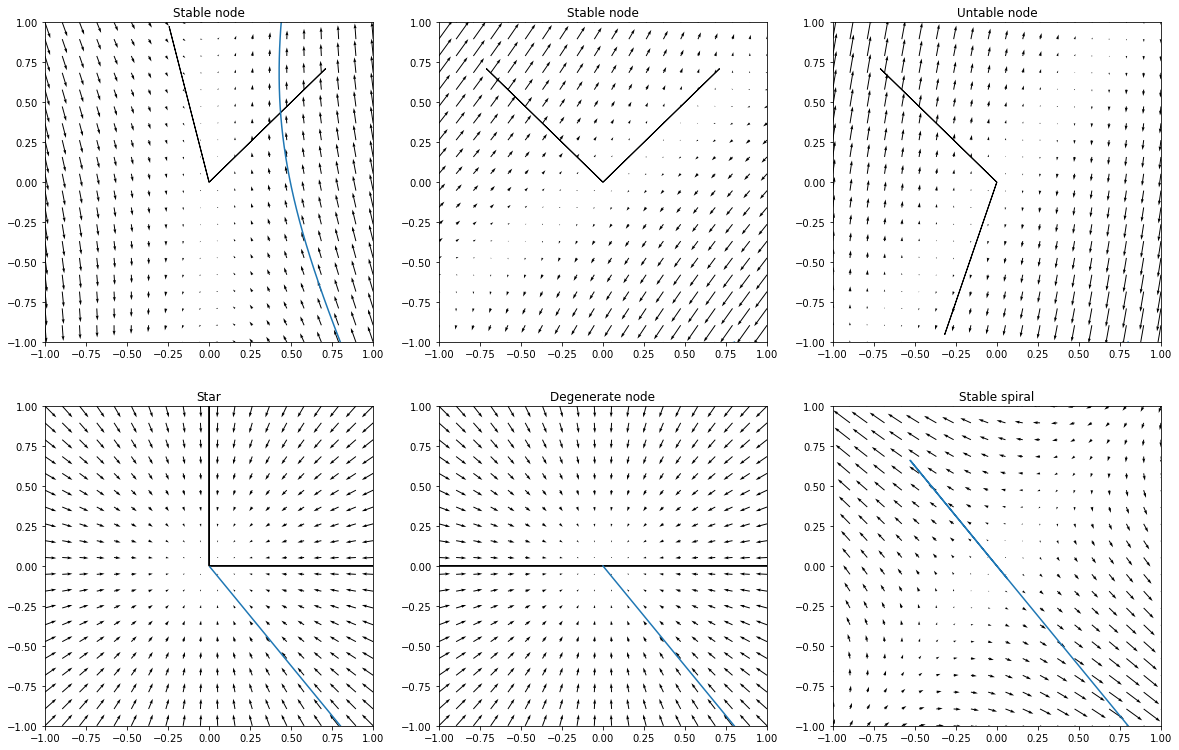

In [173]:
As = [
  (np.array([[1, 1], [4, -2]]), "Stable node"),
  (np.array([[0.5, 1], [1, 0.5]]), "Stable node"),
  (np.array([[2, 1], [3, 4]]), "Untable node"),
  (np.array([[-1, 0], [0, -1]]), "Star"),
  (np.array([[-3, 2], [0, -3]]), "Degenerate node"),
  # (np.array([[1, -4], [4, -2]]), "Stable spiral"),
  (np.array([[3, 0.5], [0.5, 3]]), "Unstable spiral"),
  (np.array([[1, 0], [0, -1]]), "Center"),
]

TIME_STEPS = 500
T0, T1 = (-10, 10)
Ts = np.linspace(T0, T1, TIME_STEPS)

coords = np.linspace(-1, 1, 20)
XY = np.array([(x, y) for y in coords for x in coords]).reshape([20, 20, 2])
X, Y = np.meshgrid(coords, coords)

def get_eigenbasis_transform_matrix(A, egval1, egval2):
  return np.array([[A[1, 1] * egval1, -A[0, 1] * egval1], [-A[1, 0] * egval2, A[0, 0] * egval2]]) / np.linalg.det(A)

def transform_to_eigenbasis(v, R):
  return np.dot(R, v)

def transform_from_eigenbasis(v, R):
  return np.dot(np.linalg.inv(R), v)

for idx, (A, title) in enumerate(As, start=1):
  (egval1, egval2), egvecs = linalg.eig(A)
  egvec1, egvec2 = egvecs.T
  print(egval1, egval2)
  R = get_eigenbasis_transform_matrix(A, egval1, egval2)

  U, V = np.array([np.dot(np.linalg.inv(R), np.array([egval1, egval2]).T * np.dot(R, [x, y])) for y in coords for x in coords]).reshape([-1, 2]).T
  
  xs = np.zeros([TIME_STEPS, 2])
  for idx2, x in enumerate(xs):
    if idx2 == 0:
      xs[idx2, :] = [0.8, -1]
      continue

    t = idx2 * 0.01
    xs[idx2, :] = transform_from_eigenbasis(transform_to_eigenbasis(xs[0, :], R) * [np.exp(egval1 * t), np.exp(egval2 * t)], R)

  plt.subplot(3, 3, idx)
  plt.title(title)
  plt.gca().set_xlim([-1, 1])
  plt.gca().set_ylim([-1, 1])

  plt.quiver(X, Y, U, V)
  plt.plot(xs[:, 0].real, xs[:, 1].real)

  plt.arrow(0, 0, egvec1[0], egvec1[1])
  plt.arrow(0, 0, egvec2[0], egvec2[1])